# **Marketing Data Analysis**
**par Mohamed LAAJAJ**

---

## **Introduction**

**Objectif :**  
L'entreprise "A" a effectué plusieures campagnes marketing et souhaite mieux comprendre les résultats.

**Section 1: Exploration des données**  
* Import de nos données
* Vérification du format & type de données 
* Création/modification de colonnes si besoin
* Analyse univariée de nos données (moyenne, médiane, mode, quartile)
* Pré-traitement : présence de valeurs extrêmes ou incorrectes ? 

**Section 2: Analyse statistique bivariée**  
Nous allons dans cette partie effectuer plusieurs tests statistiques (ANOVA, Chi², T-Test) afin de comprendre les relations entre nos variables.
Example de questions : 
* Relation entre la réponse à la campagne et les données quantitatives avec un test ANOVA 
* Relation entre la réponse à la campagne et les données quantitatives avec un test de Chi²
* Relation entre nos variables quantitatives à l'aide d'un test de correlation

**Section 3: Création d'un modèle simple de Machine Learning**  
Après avoir analysé les relationns entre nos variables, nous pouvons construire un modèle simple de Machine Learning permettant de prédire les réponses à la campagne marketing, et donc de mieux cibler les prochaines campagnes.

* Choix des variables et des modèles
* Création d'une fonction permettant d'évaluer plusieurs modèles
* Résultats


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')
pd.set_option('display.max.columns', 100)
pd.set_option('display.max.rows', 200)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

---

## **Section 1 - Exploration univariée de nos données**


* L'objectif de cette partie est d'avoir une vue globale sur notre jeu de données.  
    * Types de données 
    * Création de colonnes   
    * Statistiques descriptives  
    * Valeurs manquantes, extrêmes ?    

In [3]:
#Import de nos données
data = pd.read_excel('Excel/marketing_campaign.xlsx')
data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.00000,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.00000,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.00000,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.00000,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.00000,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [4]:
data.shape

(2240, 29)

### **Types de données & création de colonnes**

In [5]:
data.dtypes

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

**Remarques :**

Nous avons **3** variables qualitatives et **26** variables quantitatives.

Pour rappel, nous souhaitons savoir si une personne a, au moins répondu, à une enquête.  

Nous allons créer plusieurs variables: 

-   **Reponse** : Nous avons plusieurs colonnes qui indiquent la réponse à une campagne. Ces colonnes commencent toutes par **"AcceptedCmp"**. 'Oui' si la somme des colonnes > 0, non si la somme est égale à 0.

-   **Age** : Différence entre la date de réponse **Dt_Customer** et **Year_Birth**.  

-   **Enfant** : La personne a-t-elle des enfants ? Oui si la somme entre **KidHome** et **Teenhome** >0.

-   **Depenses** : Somme de toutes les colonnes 'Mnt'

Nous allons jeter un coup d'oeil aux colonnes **Z_CostContact** & **Z_Revenue**.


In [6]:
# Commençons par obtenir l'ensemble des colonnes 'Accepted'

accepted = [col for col in data.columns if 'Accepted' in col]
accepted

['AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2']

In [7]:
# Enfin, créons notre nouvelle colonne 'Reponse' qui aura pour valeur 'oui/non'
# La personne a-t-elle acceptée ? 

data['Reponse'] = np.where(data[accepted].sum(axis=1)>0, 'oui','non')

In [8]:
# Création de la colonne Age 

data['Age'] = pd.to_datetime(data['Dt_Customer']).dt.year - data['Year_Birth'] 


In [9]:
# Regardons les colonnes Z_CostContact et Z_Revenue

data.Z_CostContact.unique(), data.Z_Revenue.unique()

(array([3]), array([11]))

Nous allons supprimer de notre jeu de données les colonnes **Z_CostContact**, **Z_Revenue**.

In [10]:
# Création de la colonne Enfants
# La personne a-t-elle des enfants ? 


data['Enfant'] = np.where(data.Kidhome + data.Teenhome > 0, 'Oui', 'Non')

In [11]:
# Création de la colonne "Dépenses"

mnt = [n for n in data.columns if 'Mnt' in n]

data['Depenses'] = data[mnt].sum(axis=1)

In [12]:
# Partons de la liste accepted. Nous allons l'alimenter avec les autres colonnes

accepted.extend(['Teenhome','Kidhome', 'Z_CostContact', 'Z_Revenue','Dt_Customer','Year_Birth','Response','ID'])
accepted.extend(mnt)

In [13]:
accepted

['AcceptedCmp3',
 'AcceptedCmp4',
 'AcceptedCmp5',
 'AcceptedCmp1',
 'AcceptedCmp2',
 'Teenhome',
 'Kidhome',
 'Z_CostContact',
 'Z_Revenue',
 'Dt_Customer',
 'Year_Birth',
 'Response',
 'ID',
 'MntWines',
 'MntFruits',
 'MntMeatProducts',
 'MntFishProducts',
 'MntSweetProducts',
 'MntGoldProds']

In [14]:
df = data.drop(columns = accepted)

In [15]:
df.head()

,Education,Marital_Status,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Reponse,Age,Enfant,Depenses
0,Graduation,Single,58138.00000,58,3,8,10,4,7,0,non,55,Non,1617
1,Graduation,Single,46344.00000,38,2,1,1,2,5,0,non,60,Oui,27
2,Graduation,Together,71613.00000,26,1,8,2,10,4,0,non,48,Non,776
3,Graduation,Together,26646.00000,26,2,2,0,4,6,0,non,30,Oui,53
4,PhD,Married,58293.00000,94,5,5,3,6,5,0,non,33,Oui,422


### **Statistiques descriptives**

In [16]:
# Création d'une fonction qui affiche un DataFrame contenant une analyse univariée de notre jeu de données.

def stats_descriptives(df, col=None): 
    #La fonction prend en entrée un DataFrame et, optionnelement, une colonne nous permettant de filter notre résultat final.
    
    # Le résultat final est un dataframe contenant les colonnes suivantes.
    output = pd.DataFrame(columns = ['Type', 'Count', 'Valeurs Manquantes', 'Nb Valeurs uniques' ,'Mode', 'Moyenne', 'Min', 
    'Q1', 'Median', 'Q3', 'Max', 'Skewness', 'Kurtosis'])
    
    # Vérification si l'argument optionnel est utilisé ou non
    if col == None:
        cols= df.columns
    else:
        cols = [col]

    # La fonction va effectuer une boucle sur l'ensemble des colonnes. 
    for element in cols:

        # Ici, la fonction va d'abord filtrer sur les données de type quantitatives.
        # Nous ne pouvons en effet pas calculer de moyenne sur des données qualitatives. 
        if pd.api.types.is_numeric_dtype(df[element]) :
            type = df[element].dtype
            count = df[element].count()
            v_m = df[element].isnull().sum()
            v_u = df[element].nunique()
            mode = df[element].mode()[0]
            moyenne = round(df[element].mean(),2)
            min = df[element].min()
            q1 = df[element].quantile(0.25)
            median = df[element].median()
            q3 = df[element].quantile(0.75)
            max = df[element].max()
            skewness = round(df[element].skew(),3)
            kurtosis = round(df[element].kurtosis(),3)

            output.loc[element] = [type,count,v_m,v_u,mode,moyenne,min,q1,median,q3,max,skewness,kurtosis]

        else:
            type = df[element].dtype
            count = df[element].count()
            v_m = df[element].isnull().sum()
            v_u = df[element].nunique()
            mode = df[element].mode()[0]
            
            output.loc[element] = [type,count,v_m,v_u,mode,'-','-','-','-','-','-','-','-']

    return output.sort_values(by='Type')        



In [17]:
stats_descriptives(df)

,Type,Count,Valeurs Manquantes,Nb Valeurs uniques,Mode,Moyenne,Min,Q1,Median,Q3,Max,Skewness,Kurtosis
Recency,int64,2240,0,100,56,49.11000,0,24.00000,49.00000,74.00000,99,-0.00200,-1.20200
NumDealsPurchases,int64,2240,0,15,1,2.33000,0,1.00000,2.00000,3.00000,15,2.41900,8.93700
NumWebPurchases,int64,2240,0,15,2,4.08000,0,2.00000,4.00000,6.00000,27,1.38300,5.70300
NumCatalogPurchases,int64,2240,0,14,0,2.66000,0,0.00000,2.00000,4.00000,28,1.88100,8.04700
NumStorePurchases,int64,2240,0,14,3,5.79000,0,3.00000,5.00000,8.00000,13,0.70200,-0.62200
NumWebVisitsMonth,int64,2240,0,16,7,5.32000,0,3.00000,6.00000,7.00000,20,0.20800,1.82200
Complain,int64,2240,0,2,0,0.01000,0,0.00000,0.00000,0.00000,1,10.18900,101.90600
Age,int64,2240,0,61,41,44.22000,16,36.00000,43.00000,54.00000,121,0.35100,0.73700
Depenses,int64,2240,0,1054,46,605.80000,5,68.75000,396.00000,1045.50000,2525,0.86100,-0.34200
Income,float64,2216,24,1974,7500.00000,52247.25000,1730.00000,35303.00000,51381.50000,68522.00000,666666.00000,6.76300,159.63700


Quelques informations: 

-   **Valeurs manquantes** : 24 valeurs manquantes pour la colonne **Income**

-   **Valeurs extrêmes** : Présence de valeurs extrêmes dans la colonne **Income** (666666.0)

-   **Shapiro Test** : Aucune de nos variables quantitatives ne suit une distribution normale. 


### **Gestion des valeurs extrêmes et des valeurs manquantes (données quantitatives)**

#### **Les valeurs extrêmes**

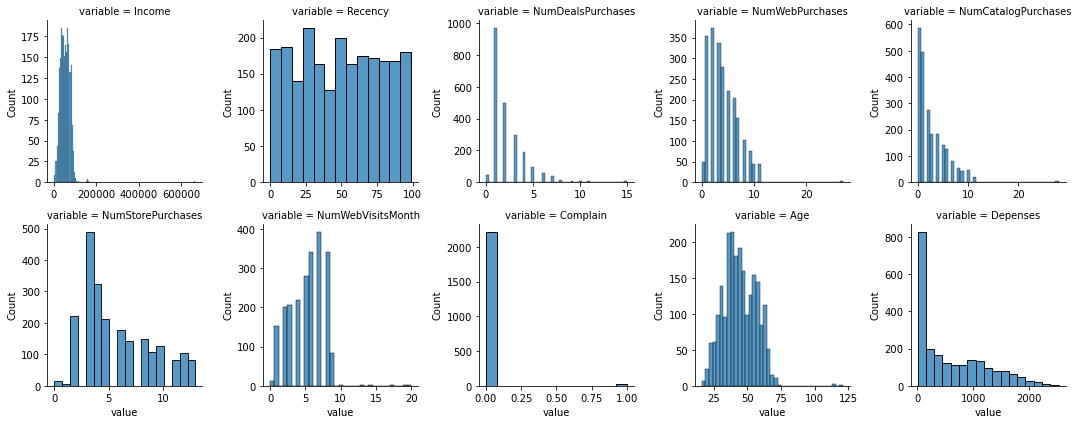

In [18]:
num_col = [n for n in df.select_dtypes(np.number).columns ]

output = pd.DataFrame(data=df, columns=num_col)

nd = pd.melt(output, value_vars =output )
n1 = sns.FacetGrid (nd, col='variable', col_wrap=5, sharex=False, sharey = False)
n1 = n1.map(sns.histplot, 'value')
n1

In [19]:
# Utilisation de l'écart interquartile pour détecter les valeurs extrêmes.

def ecart_interquartile(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3-Q1
    limite_basse = Q1-1.5*IQR
    limite_haute = IQR+1.5*IQR 
    return limite_basse, limite_haute

# Nous pouvons par la suite filtrer notre jeu de données sur ces valeurs pour tenter de les comprendre.

In [20]:
ecart_interquartile(df,'Income')

(-14525.5, 83047.5)

Pour la colonne **Income**, toutes les valeurs qui sont inférieurs à 0 (ici valeurs négatives) ou supérieurs à 83047.5 sont considérées comme des valeurs extrêmes.  
Nous allons uniquement supprimer les valeurs pour lesquelles le salaire est supérieur à 600.000 et les âges supérieurs à 100 ans

In [21]:
# Supprimons les valeurs extrêmes 
df = df[(df['Income']< 600000) & (df['Age']< 100) ]


In [22]:
df.Income.max()

162397.0

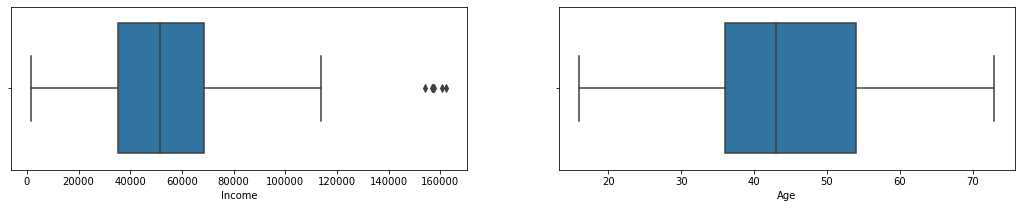

In [23]:
fig, axes = plt.subplots(1,2, figsize=(18,3))
sns.boxplot(ax= axes[0], data = df, x='Income')
sns.boxplot(ax= axes[1], data = df, x='Age')
plt.show()

#### **Les valeurs manquantes**

Il y a plusieurs manières de "gérer" les données manquantes:
* Supprimer les lignes qui contiennent des valeurs manquantes  
* Remplacer les valeurs par une estimation (médiane)  
* Utiliser un algorithme KNN pour analyser les données et remplacer les données manquantes par les valeurs du groupe.  

In [24]:
# Nous allons utiliser la dernière méthode : la méthode KNN

from sklearn.impute import KNNImputer

imputer = KNNImputer()

imputer = KNNImputer(n_neighbors=5,metric='nan_euclidean')

# fit on the dataset
imputer.fit(df[['Income','Age','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth','Depenses']])

# transform the dataset
X = imputer.transform(df[['Income','Age','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth','Depenses']])

Income_impute=pd.DataFrame(X,columns=['Income','Age','NumDealsPurchases','NumWebPurchases','NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth','Depenses'])


df['Income']=Income_impute['Income'].values

df.isnull().sum()

Education              0
Marital_Status         0
Income                 0
Recency                0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
Complain               0
Reponse                0
Age                    0
Enfant                 0
Depenses               0
dtype: int64

### **Nos variables qualitatives**

In [25]:
cat_col = [col for col in df.select_dtypes('object').columns]

for col in cat_col:
    print(col)
    print(f"Nbre de valeurs uniques : {df[col].nunique()}")
    print(df[col].unique())
    print('---------')

Education
Nbre de valeurs uniques : 5
['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
---------
Marital_Status
Nbre de valeurs uniques : 8
['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']
---------
Reponse
Nbre de valeurs uniques : 2
['non' 'oui']
---------
Enfant
Nbre de valeurs uniques : 2
['Non' 'Oui']
---------


In [26]:
# Jetons un coup d'oeil à la colonne 'Marital_Status'
df['Marital_Status'].value_counts()

Married     857
Together    571
Single      470
Divorced    231
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [27]:
# Nous allons remplacer les valeurs YOLO, Absurd et Alone par Single

valeurs = ["YOLO",'Absurd','Alone']

def valeurs_remplacer(x):
    if x in valeurs:
        return 'Single'
    else:
        return x

df['Marital_Status'] =  df['Marital_Status'].apply(lambda x : valeurs_remplacer(x))

> Conclusion de la partie:
>  * Test 

---

## **Quelques visualisations**


### **Relation entre la Reponse et nos variables quantitatives**

In [28]:
def cat_num_plot(df, num_col, cat_col='Reponse'):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1,3, figsize=(20,3))
    sns.histplot(ax = axes[0], data = df, x=num_col, hue=cat_col, kde=True)
    sns.boxenplot(ax = axes[1], data=df, y=num_col, x=cat_col);
    sns.pointplot(ax = axes[2], data=df, y=num_col, x=cat_col);
    plt.show()

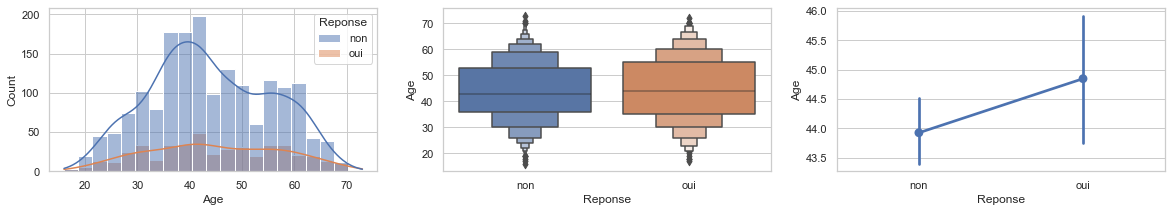

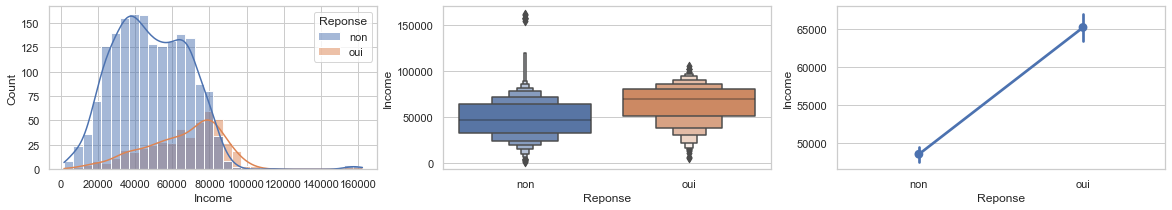

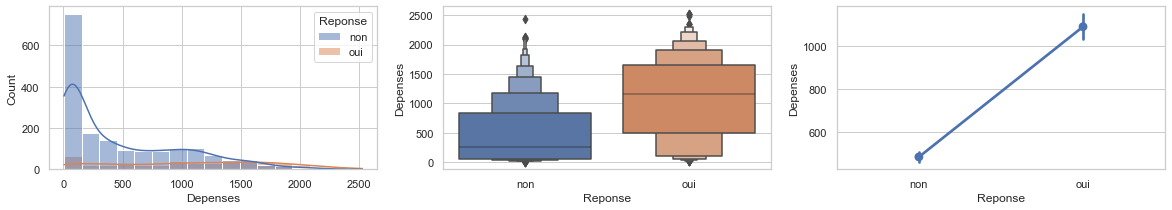

In [29]:
num_col = ['Age','Income','Depenses']

for element in num_col:
    cat_num_plot(df,element)

### **Relation entre la Reponse et nos variables qualitatives**

---

## **Section 2 - Tests statistiques**


In [30]:
num_col

['Age', 'Income', 'Depenses']

In [31]:
X=num_col

column_dict= {elem : pd.DataFrame() for elem in X}

def shapiro_test(data):
    stat, p = stats.shapiro(data)
    print('%s : W=%.3f, p=%.3f' % (column,stat, p))
    alpha = 0.05
    if p > alpha:
        print("L'échantillon suit une loi normale (On ne rejette pas (H0)")
    else:
        print("L'échantillon ne suit pas une loi normale (On rejette l'hypothèse (H0)")

for column in X:
    column_dict[column] = df[column]
    shapiro_test(column_dict[column])

Age : W=0.984, p=0.000
L'échantillon ne suit pas une loi normale (On rejette l'hypothèse (H0)
Income : W=0.975, p=0.000
L'échantillon ne suit pas une loi normale (On rejette l'hypothèse (H0)
Depenses : W=0.865, p=0.000
L'échantillon ne suit pas une loi normale (On rejette l'hypothèse (H0)


#### **Numerical variables : Mann-Whitney's test**

Our first question was to find if the average income of PhD owners is statistically different from the average income of Master owners.

Notre première question est de savoir si le salaire moyen différe du niveau d'éducation

1. Hypothèses
* H_0 : Le salaire moyen ne différe pas
* H_1 : Le salaire moyen différe

2. Analysis plan formulation

Significance level : We will test our hypothesis at a 5% significance level

Test method : We use the Mann-Whitney's test to determine whether one group has higher or lower income than the other group. 
Mann-Whitney U test is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution. The default assumption or null hypothesis is that there is no difference between the distributions of the data samples. Rejection of this hypothesis suggests that there is likely some difference between the samples. More specifically, the test determines whether it is equally likely that any randomly selected observation from one sample will be greater or less than a sample in the other distribution. If violated, it suggests differing distributions. 
Therefore, if our assumption is correct, the result of the test should enable us to reject the null hypothesis.

In [32]:
# Définissons notre fonction
# Nous allons utiliser le test Mann-Whitney

from itertools import combinations

def rank_test(num_col, cat_col, df=df):
    # 1ere etape : Les valeurs uniques 
    valeurs_uniques = df[cat_col].unique()
    output = pd.DataFrame(columns=['Score','p_value','p','p_ajusté','résultat'])

    # Si le nombre de valeurs uniques est supérieurs à 2, 
    # cela signifie que nous avons plusieurs groupes.
    # Nous allons calculer toutes les combinaisons possibles.
    if len(valeurs_uniques)>2:
        comb = list(combinations(valeurs_uniques,2))
        # Calcul de la p_valeur ajustée
        alpha = 0.05/len(comb)
        for element in comb:
            v, v1 = element
            g1 = df[df[cat_col]==v][num_col] #1er groupe
            g2 = df[df[cat_col]==v1][num_col] #2eme groupe
            stat, p = stats.mannwhitneyu(g1,g2)
            if round(p,3)<alpha:
                output.loc[f'{v} vs {v1}'] = [stat,round(p,4),0.05,alpha,'Test significatif']
            else:
                output.loc[f'{v} vs {v1}'] = [stat,round(p,4),0.05,alpha,'Test non significatif']
    else:
        groups = []
        alpha = 0.05
        for element in valeurs_uniques:
            groups.append(df[df[cat_col]==element][num_col])
        stat, p = stats.mannwhitneyu(groups[0], groups[1])
        if p<alpha:
            output.loc[f'{valeurs_uniques[0]} vs {valeurs_uniques[1]}'] = [stat,round(p,4),alpha,'-','Test significatif']
        else:
            output.loc[f'{valeurs_uniques[0]} vs {valeurs_uniques[1]}'] = [stat,round(p,4),alpha,'-','Test non significatif']       

    return output
    

In [33]:
rank_test('Income','Education')

,Score,p_value,p,p_ajusté,résultat
Graduation vs PhD,242575.00000,0.00300,0.05000,0.00500,Test significatif
Graduation vs Master,200028.50000,0.62560,0.05000,0.00500,Test non significatif
Graduation vs Basic,55864.00000,0.00000,0.05000,0.00500,Test significatif
Graduation vs 2n Cycle,123355.50000,0.00830,0.05000,0.00500,Test non significatif
PhD vs Master,95125.50000,0.03230,0.05000,0.00500,Test non significatif
PhD vs Basic,25259.00000,0.00000,0.05000,0.00500,Test significatif
PhD vs 2n Cycle,57800.50000,0.00000,0.05000,0.00500,Test significatif
Master vs Basic,18786.00000,0.00000,0.05000,0.00500,Test significatif
Master vs 2n Cycle,41207.50000,0.00590,0.05000,0.00500,Test non significatif
Basic vs 2n Cycle,1366.00000,0.00000,0.05000,0.00500,Test significatif


In [34]:
rank_test('Income','Marital_Status')

,Score,p_value,p,p_ajusté,résultat
Single vs Together,132721.50000,0.47810,0.05000,0.00500,Test non significatif
Single vs Married,200187.50000,0.53280,0.05000,0.00500,Test non significatif
Single vs Divorced,52025.50000,0.22930,0.05000,0.00500,Test non significatif
Single vs Widow,15175.00000,0.02260,0.05000,0.00500,Test non significatif
Together vs Married,245695.00000,0.89360,0.05000,0.00500,Test non significatif
Together vs Divorced,63892.50000,0.48860,0.05000,0.00500,Test non significatif
Together vs Widow,18600.00000,0.04300,0.05000,0.00500,Test non significatif
Married vs Divorced,95547.50000,0.41760,0.05000,0.00500,Test non significatif
Married vs Widow,27950.00000,0.04040,0.05000,0.00500,Test non significatif
Divorced vs Widow,7852.00000,0.16800,0.05000,0.00500,Test non significatif


In [35]:
rank_test('Income','Reponse')

,Score,p_value,p,p_ajusté,résultat
non vs oui,216112.00000,0.00000,0.05000,-,Test significatif


In [36]:
rank_test('Depenses','Reponse')

,Score,p_value,p,p_ajusté,résultat
non vs oui,192238.00000,0.00000,0.05000,-,Test significatif


In [37]:
rank_test('Depenses','Marital_Status')

,Score,p_value,p,p_ajusté,résultat
Single vs Together,136226.00000,0.99310,0.05000,0.00500,Test non significatif
Single vs Married,205532.00000,0.86610,0.05000,0.00500,Test non significatif
Single vs Divorced,55059.50000,0.98950,0.05000,0.00500,Test non significatif
Single vs Widow,15485.50000,0.04130,0.05000,0.00500,Test non significatif
Together vs Married,246265.00000,0.83490,0.05000,0.00500,Test non significatif
Together vs Divorced,65709.00000,0.93530,0.05000,0.00500,Test non significatif
Together vs Widow,18419.50000,0.03220,0.05000,0.00500,Test non significatif
Married vs Divorced,98148.00000,0.84380,0.05000,0.00500,Test non significatif
Married vs Widow,27341.50000,0.02030,0.05000,0.00500,Test non significatif
Divorced vs Widow,7552.50000,0.06800,0.05000,0.00500,Test non significatif


In [38]:
rank_test('NumWebVisitsMonth','Reponse')

,Score,p_value,p,p_ajusté,résultat
non vs oui,472464.50000,0.00000,0.05000,-,Test significatif


#### **Chi Square**

In [39]:
def chi_square(var1, var2='Reponse', df=df):
    table = pd.crosstab(df[var1], df[var2])
    output = stats.chi2_contingency(table)
    stat, p = output[0], output[1]
    return stat, round(p,3)

In [40]:
chi_square('Enfant','Marital_Status')

(15.576875363520237, 0.004)

In [41]:
v = df.select_dtypes('object').columns
v.drop("Reponse")

Index(['Education', 'Marital_Status', 'Enfant'], dtype='object')

In [42]:
for element in v:
    stat, p = chi_square(element)
    print(element)
    print(stat,p)

Education
5.95702454038447 0.202
Marital_Status
0.7801766998245534 0.941
Reponse
2205.913381041597 0.0
Enfant
123.4216131064118 0.0


#### **Spearman**

In [43]:
def spearman(col1,col2,df=df):
    stat, p = stats.spearmanr(df[col1],df[col2])
    return stat, round(p,4)

In [44]:
spearman('Income','Age')

(0.21702144250931768, 0.0)

___

## **Section 3 - Préparation de nos données**


### **Selection de nos colonnes**

In [45]:
dataset = df.copy()

In [46]:
dataset.drop(columns=['Education','Marital_Status'], inplace=True)

In [47]:
dataset['Reponse'] = np.where(df['Reponse']=='oui',1,0)
dataset['Enfant'] = np.where(df['Enfant']=='oui',1,0)

In [48]:
dataset  = pd.get_dummies(dataset)

In [49]:
for element in dataset.columns:
    stat, p = spearman(element,'Reponse')
    print(element)
    print(stat,p)

Income
0.32421148702489455 0.0
Recency
-0.016019818127448755 0.4514
NumDealsPurchases
-0.12587216308886617 0.0
NumWebPurchases
0.2337966278702364 0.0
NumCatalogPurchases
0.34988471733533066 0.0
NumStorePurchases
0.19514384215648845 0.0
NumWebVisitsMonth
-0.12478289366680771 0.0
Complain
-0.025236486294918106 0.2354
Reponse
0.9999999999999999 0.0
Age
0.030567126098207283 0.1507
Enfant
-0.23744746134338454 0.0
Depenses
0.3659269507560391 0.0


In [50]:
dataset = dataset.drop(columns=['Age','Complain','Recency'])

### **Standardisation de nos colonnes**

In [51]:
dataset

,Income,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Reponse,Enfant,Depenses
0,58138.00000,3,8,10,4,7,0,0,1617
1,46344.00000,2,1,1,2,5,0,0,27
2,71613.00000,1,8,2,10,4,0,0,776
3,26646.00000,2,2,0,4,6,0,0,53
4,58293.00000,5,5,3,6,5,0,0,422
...,...,...,...,...,...,...,...,...,...
2235,61223.00000,2,9,3,4,5,0,0,1341
2236,64014.00000,7,8,2,5,7,1,0,444
2237,56981.00000,1,2,3,13,6,1,0,1241
2238,69245.00000,2,6,5,10,3,0,0,843


In [52]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = dataset.drop(columns=['Reponse'])
y = dataset['Reponse']

X = scaler.fit_transform(X)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

---

## **Section 4 - Modèle Machine Learning**


In [94]:
from sklearn.model_selection import cross_val_score

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

model_random_forest = RandomForestClassifier(random_state=42)

model_random_forest = RandomizedSearchCV(
    model_random_forest, 
    param_grid, 
    n_iter=5,
    scoring='accuracy',
)

model_random_forest.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_random_forest.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_random_forest.best_score_:.3f}'
)
print('-----')

-----
Best parameters {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 6, 'criterion': 'gini'}
Mean cross-validated accuracy score of the best_estimator: 0.837
-----


In [95]:
model_random_forest.score(X_test, y_test)

0.833634719710669

In [96]:
model_random_forest.score(X_test,y_test)

0.833634719710669

In [97]:
from sklearn.model_selection import cross_val_score

param_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}


model_logistic_regression = LogisticRegression()

model_logistic_regression = RandomizedSearchCV(
    model_logistic_regression, 
    param_grid, 
    n_iter=5,
    scoring='accuracy',
)

model_logistic_regression.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_logistic_regression.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_logistic_regression.best_score_:.3f}'
)
print('-----')

-----
Best parameters {'penalty': 'l2', 'C': 10.0}
Mean cross-validated accuracy score of the best_estimator: 0.822
-----


In [98]:
model_logistic_regression.score(X_test,y_test)

0.8155515370705244

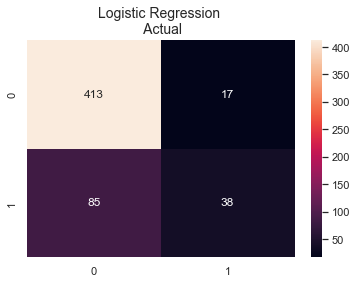

In [99]:
from sklearn.metrics import confusion_matrix

y_pred = model_logistic_regression.predict(X_test)

sns.heatmap(confusion_matrix(y_test,y_pred), annot =True, fmt='g')
plt.title("Logistic Regression \n Actual", fontsize=14)
plt.show()

In [100]:
confusion_matrix(y_test,y_pred)

array([[413,  17],
       [ 85,  38]])

In [101]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       430
           1       0.69      0.31      0.43       123

    accuracy                           0.82       553
   macro avg       0.76      0.63      0.66       553
weighted avg       0.80      0.82      0.79       553



In [102]:
dataset.Reponse.value_counts()

0    1754
1     458
Name: Reponse, dtype: int64

____

## **Section 5 - Utilisation de la PCA pour améliorer le modèle**


In [103]:
from sklearn.decomposition import PCA


pca = PCA()
pca.fit(X)
pca.explained_variance_ratio_

array([0.55332146, 0.2066667 , 0.08682757, 0.06974389, 0.04988832,
       0.03355206])

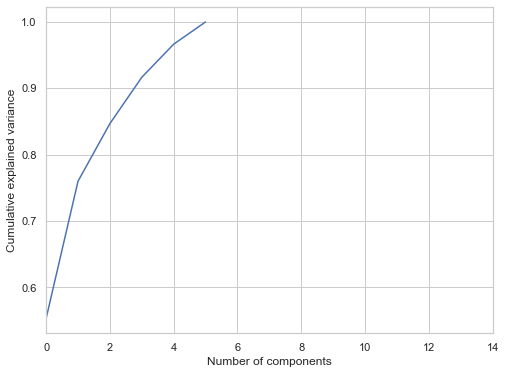

In [104]:
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,14,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [105]:
X = dataset.drop(columns=['Reponse'])
y = dataset['Reponse']

X = scaler.fit_transform(X)

pca = PCA(0.95)

X = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [106]:
from sklearn.model_selection import cross_val_score

param_grid = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}


model_logistic_regression = LogisticRegression()

model_logistic_regression = RandomizedSearchCV(
    model_logistic_regression, 
    param_grid, 
    n_iter=5,
    scoring='accuracy',
)

model_logistic_regression.fit(X_train, y_train)

print('-----')
print(f'Best parameters {model_logistic_regression.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: '+ \
    f'{model_logistic_regression.best_score_:.3f}\n'
    f'Score : {round(model_logistic_regression.score(X_test,y_test),3)}'
)
print('-----')

-----
Best parameters {'penalty': 'l2', 'C': 100.0}
Mean cross-validated accuracy score of the best_estimator: 0.822
Score : 0.816
-----


In [107]:
from sklearn.metrics import classification_report

y_pred = model_logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.96      0.89       430
           1       0.69      0.31      0.43       123

    accuracy                           0.82       553
   macro avg       0.76      0.63      0.66       553
weighted avg       0.80      0.82      0.79       553

